# FER+ - all classes
**Author**: Johannes S. Fischer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime

In [2]:
model_name = 'FERplus-impr-std'

Load pretrained model to fine-tune it? If yes, specify model name, if no set it to ```None```.

In [3]:
pretrained_model_name = None

# Data

## Preprocessing Function
Preprocessing function like for VGG16, where pixel values per channel are normalized to have zero mean (```tensorflow``` implementation can be found [here](https://github.com/keras-team/keras/blob/2c48a3b38b6b6139be2da501982fd2f61d7d48fe/keras/applications/imagenet_utils.py#L168)).

In [4]:
# FERplus 2013 training data mean and std
mean = [129.4432, 129.4432, 129.4432]
std = [64.87448751, 64.87448751, 64.87448751]

def preprocess(x):
    # ensure image format
    x = np.array(x, dtype='float32')
    
    # normalize
    x[..., 0] -= mean[0]
    x[..., 1] -= mean[1]
    x[..., 2] -= mean[2]
    if std is not None:
        x[..., 0] /= std[0]
        x[..., 1] /= std[1]
        x[..., 2] /= std[2] 
    return x

def de_preprocess(x):
    if std is not None:
        x[..., 0] *= std[0]
        x[..., 1] *= std[1]
        x[..., 2] *= std[2]
    # normalize
    x[..., 0] += mean[0]
    x[..., 1] += mean[1]
    x[..., 2] += mean[2]
    return x.astype('uint8')

## Load Data

In [5]:
%%time

from Dataloader import load_FERplus_targetvector

# settings
DATA_DIR = './data/ferplus2013/'

IMG_SIZE = (100, 100)
IMG_SHAPE = IMG_SIZE + (3,)

BATCH_SIZE = 64

# load data
train_ds, val_ds, test_ds = load_FERplus_targetvector(DATA_DIR,
                                                      target_img_size=IMG_SIZE,
                                                      batch_size=BATCH_SIZE,
                                                      preprocessing_function=preprocess)

Training
- (28557, 100, 100, 3) 
- (28557, 7)
Validation
- (3573, 100, 100, 3) 
- (3573, 7)
Testing
- (3579, 100, 100, 3) 
- (3579, 7)
Wall time: 1min 1s


Prepare some function to get labels...

In [6]:
emotion_labels = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']

num_classes = len(emotion_labels)
print("Number of classes: ", num_classes)

def vec2label(onehot_vec):
    major_vote = np.argmax(onehot_vec)
    return emotion_labels[major_vote]

Number of classes:  7


## Data Examples

Show some examples...

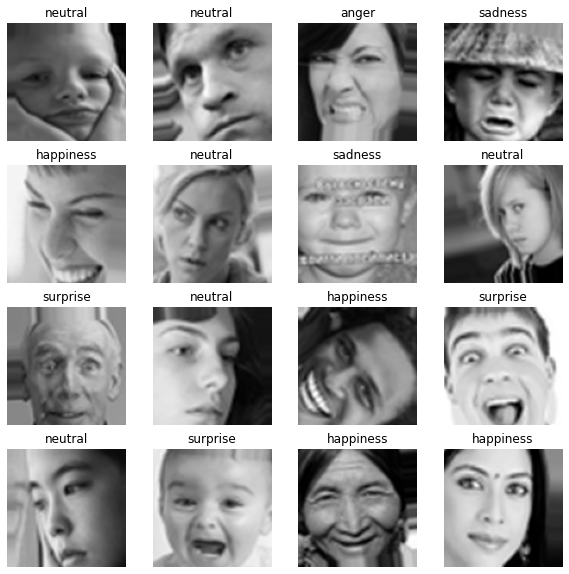

In [7]:
images, labels = next(train_ds)

plt.subplots(4,4, figsize=(10, 10))
for i in range(16):
    plt.subplot(4,4, i+1)
    plt.imshow(
        de_preprocess(images[i])
    )
    plt.title(vec2label(labels[i]))
    plt.axis('off')
plt.show()

# Model

## Base model
Architecture of the model without classification layer.

In [8]:
from ModelGenerator import get_base_model2

# get base model
model = get_base_model2(IMG_SHAPE)

## Classification model
Add classification layer to the base model.

In [9]:
# add classification layer (softmax)
model.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="softmax"))

# load pretrained version if required
if pretrained_model_name is not None:
    model.load_weights(f'./models/{pretrained_model_name}')

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (ConvLayer)     (None, 100, 100, 64)      2048      
_________________________________________________________________
block1_conv2 (ConvLayer)     (None, 100, 100, 64)      37184     
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 33, 33, 64)        0         
_________________________________________________________________
block2_conv1 (ConvLayer)     (None, 33, 33, 96)        55776     
_________________________________________________________________
block2_conv2 (ConvLayer)     (None, 33, 33, 96)        83424     
_________________________________________________________________
block2_conv3 (ConvLayer)     (None, 33, 33, 96)        83424     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 11, 11, 96)        0

# Training

In [10]:
# callbacks
dt = datetime.now().strftime("%m%d-%H%M")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=f"./modelcheckpoints/{model_name}_{dt}",
                                       monitor='val_accuracy',
                                       save_best_only=True,
                                       verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=3,
                                         verbose=1,
                                         mode='auto',
                                         min_lr=0.00000001),
    tf.keras.callbacks.CSVLogger(f'./log/{model_name}_{dt}.csv',
                                 separator=",", append=True)
]

In [11]:
%%time

epochs = 30

history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/30
447/447 [==============================] - 119s 245ms/step - loss: 1.6053 - accuracy: 0.3931 - val_loss: 6.7350 - val_accuracy: 0.2639

Epoch 00001: val_accuracy improved from -inf to 0.26392, saving model to ./modelcheckpoints\FERplus-impr-std_0124-1040


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


Epoch 2/30
447/447 [==============================] - 106s 237ms/step - loss: 1.2278 - accuracy: 0.6247 - val_loss: 1.1738 - val_accuracy: 0.6412

Epoch 00002: val_accuracy improved from 0.26392 to 0.64120, saving model to ./modelcheckpoints\FERplus-impr-std_0124-1040


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


Epoch 3/30
447/447 [==============================] - 98s 219ms/step - loss: 1.0320 - accuracy: 0.7096 - val_loss: 0.9822 - val_accuracy: 0.7316

Epoch 00003: val_accuracy improved from 0.64120 to 0.73160, saving model to ./modelcheckpoints\FERplus-impr-std_0124-1040


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


Epoch 4/30
447/447 [==============================] - 112s 249ms/step - loss: 0.9559 - accuracy: 0.7457 - val_loss: 0.9820 - val_accuracy: 0.7218

Epoch 00004: val_accuracy did not improve from 0.73160
Epoch 5/30
447/447 [==============================] - 111s 248ms/step - loss: 0.9144 - accuracy: 0.7706 - val_loss: 0.9334 - val_accuracy: 0.7545

Epoch 00005: val_accuracy improved from 0.73160 to 0.75455, saving model to ./modelcheckpoints\FERplus-impr-std_0124-1040


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


Epoch 6/30
447/447 [==============================] - 100s 223ms/step - loss: 0.8875 - accuracy: 0.7841 - val_loss: 0.9481 - val_accuracy: 0.7571

Epoch 00006: val_accuracy improved from 0.75455 to 0.75707, saving model to ./modelcheckpoints\FERplus-impr-std_0124-1040


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


Epoch 7/30
447/447 [==============================] - 102s 228ms/step - loss: 0.8660 - accuracy: 0.7919 - val_loss: 0.9808 - val_accuracy: 0.7459

Epoch 00007: val_accuracy did not improve from 0.75707
Epoch 8/30
447/447 [==============================] - 105s 234ms/step - loss: 0.8552 - accuracy: 0.7976 - val_loss: 0.8531 - val_accuracy: 0.7893

Epoch 00008: val_accuracy improved from 0.75707 to 0.78925, saving model to ./modelcheckpoints\FERplus-impr-std_0124-1040


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


Epoch 9/30
447/447 [==============================] - 108s 240ms/step - loss: 0.8389 - accuracy: 0.8056 - val_loss: 0.8692 - val_accuracy: 0.7750

Epoch 00009: val_accuracy did not improve from 0.78925
Epoch 10/30
447/447 [==============================] - 102s 229ms/step - loss: 0.8302 - accuracy: 0.8121 - val_loss: 0.8859 - val_accuracy: 0.7697

Epoch 00010: val_accuracy did not improve from 0.78925
Epoch 11/30
447/447 [==============================] - 104s 232ms/step - loss: 0.8193 - accuracy: 0.8171 - val_loss: 0.9523 - val_accuracy: 0.7380

Epoch 00011: val_accuracy did not improve from 0.78925

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 12/30
447/447 [==============================] - 104s 233ms/step - loss: 0.7807 - accuracy: 0.8366 - val_loss: 0.7789 - val_accuracy: 0.8324

Epoch 00012: val_accuracy improved from 0.78925 to 0.83235, saving model to ./modelcheckpoints\FERplus-impr-std_0124-1040


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


Epoch 13/30
447/447 [==============================] - 105s 235ms/step - loss: 0.7691 - accuracy: 0.8440 - val_loss: 0.7757 - val_accuracy: 0.8329

Epoch 00013: val_accuracy improved from 0.83235 to 0.83291, saving model to ./modelcheckpoints\FERplus-impr-std_0124-1040


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


Epoch 14/30
447/447 [==============================] - 106s 236ms/step - loss: 0.7643 - accuracy: 0.8488 - val_loss: 0.7756 - val_accuracy: 0.8321

Epoch 00014: val_accuracy did not improve from 0.83291
Epoch 15/30
447/447 [==============================] - 105s 233ms/step - loss: 0.7603 - accuracy: 0.8521 - val_loss: 0.7723 - val_accuracy: 0.8402

Epoch 00015: val_accuracy improved from 0.83291 to 0.84019, saving model to ./modelcheckpoints\FERplus-impr-std_0124-1040


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


Epoch 16/30
447/447 [==============================] - 105s 233ms/step - loss: 0.7580 - accuracy: 0.8516 - val_loss: 0.7726 - val_accuracy: 0.8380

Epoch 00016: val_accuracy did not improve from 0.84019
Epoch 17/30
447/447 [==============================] - 103s 231ms/step - loss: 0.7551 - accuracy: 0.8530 - val_loss: 0.7672 - val_accuracy: 0.8363

Epoch 00017: val_accuracy did not improve from 0.84019
Epoch 18/30
447/447 [==============================] - 103s 230ms/step - loss: 0.7535 - accuracy: 0.8539 - val_loss: 0.7704 - val_accuracy: 0.8380

Epoch 00018: val_accuracy did not improve from 0.84019
Epoch 19/30
447/447 [==============================] - 104s 231ms/step - loss: 0.7500 - accuracy: 0.8564 - val_loss: 0.7705 - val_accuracy: 0.8394

Epoch 00019: val_accuracy did not improve from 0.84019
Epoch 20/30
447/447 [==============================] - 106s 237ms/step - loss: 0.7495 - accuracy: 0.8563 - val_loss: 0.7691 - val_accuracy: 0.8394

Epoch 00020: val_accuracy did not improv

INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


Epoch 22/30
447/447 [==============================] - 109s 244ms/step - loss: 0.7412 - accuracy: 0.8623 - val_loss: 0.7648 - val_accuracy: 0.8421

Epoch 00022: val_accuracy improved from 0.84159 to 0.84215, saving model to ./modelcheckpoints\FERplus-impr-std_0124-1040


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


Epoch 23/30
447/447 [==============================] - 105s 235ms/step - loss: 0.7406 - accuracy: 0.8603 - val_loss: 0.7655 - val_accuracy: 0.8419

Epoch 00023: val_accuracy did not improve from 0.84215
Epoch 24/30
447/447 [==============================] - 99s 222ms/step - loss: 0.7416 - accuracy: 0.8608 - val_loss: 0.7643 - val_accuracy: 0.8430

Epoch 00024: val_accuracy improved from 0.84215 to 0.84299, saving model to ./modelcheckpoints\FERplus-impr-std_0124-1040


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


Epoch 25/30
447/447 [==============================] - 100s 223ms/step - loss: 0.7399 - accuracy: 0.8588 - val_loss: 0.7649 - val_accuracy: 0.8435

Epoch 00025: val_accuracy improved from 0.84299 to 0.84355, saving model to ./modelcheckpoints\FERplus-impr-std_0124-1040


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


Epoch 26/30
447/447 [==============================] - 102s 228ms/step - loss: 0.7379 - accuracy: 0.8618 - val_loss: 0.7646 - val_accuracy: 0.8427

Epoch 00026: val_accuracy did not improve from 0.84355
Epoch 27/30
447/447 [==============================] - 98s 220ms/step - loss: 0.7400 - accuracy: 0.8614 - val_loss: 0.7640 - val_accuracy: 0.8427

Epoch 00027: val_accuracy did not improve from 0.84355
Epoch 28/30
447/447 [==============================] - 103s 229ms/step - loss: 0.7399 - accuracy: 0.8611 - val_loss: 0.7638 - val_accuracy: 0.8438

Epoch 00028: val_accuracy improved from 0.84355 to 0.84383, saving model to ./modelcheckpoints\FERplus-impr-std_0124-1040


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-std_0124-1040\assets


Epoch 29/30
447/447 [==============================] - 105s 235ms/step - loss: 0.7393 - accuracy: 0.8624 - val_loss: 0.7639 - val_accuracy: 0.8435

Epoch 00029: val_accuracy did not improve from 0.84383
Epoch 30/30
447/447 [==============================] - 103s 231ms/step - loss: 0.7389 - accuracy: 0.8621 - val_loss: 0.7637 - val_accuracy: 0.8421

Epoch 00030: val_accuracy did not improve from 0.84383
Wall time: 53min 22s


# Results

## Training Results

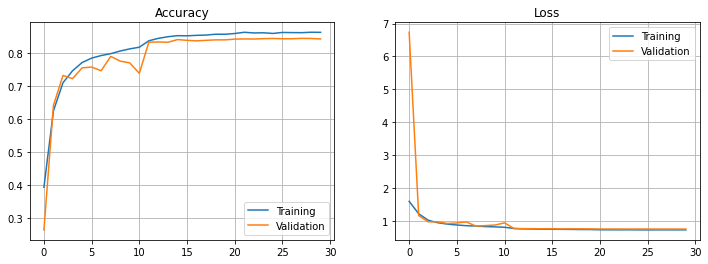

In [12]:
plt.figure(figsize=(12, 4))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.grid(); plt.legend()
# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.grid(); plt.legend()
plt.show()

## Test Results

In [13]:
loss, acc = model.evaluate(test_ds, verbose=2)

print("\nAccuracy:\t%.2f%%" % (acc * 100))
print("Loss:\t\t%.4f" % (loss))

56/56 - 4s - loss: 0.7295 - accuracy: 0.8377

Accuracy:	83.77%
Loss:		0.7295


# Save Model

In [14]:
if True:
    model.save_weights('./models/' + model_name + "_" + dt + '_weights.h5')
    model.save("./models/" + model_name + "_" + dt + "/")
    f = open("./models/info.txt", "a")
    txt = model_name + "_" + dt + ": val=" + str(np.max(history.history['val_accuracy'])*100)
    txt += "; test=" + str(acc*100) + "\n"
    f.write(txt)
    f.close()

INFO:tensorflow:Assets written to: ./models/FERplus-impr-std_0124-1040/assets


INFO:tensorflow:Assets written to: ./models/FERplus-impr-std_0124-1040/assets


---